In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Please note that this notebook is most likely going to cause a stuck process. So if you are going to run it, please make sure to restart your jupyter notebook as soon as you completed running it.

The bug happens inside the `fastText` library, which we have no control over. You can check the status of this issue: [here](https://github.com/fastai/fastai/issues/754) and [here](https://github.com/facebookresearch/fastText/issues/618#issuecomment-419554225).

For the future, note that there're 3 separate implementations of fasttext, perhaps one of them works:
https://github.com/facebookresearch/fastText/tree/master/python
https://pypi.org/project/fasttext/
https://radimrehurek.com/gensim/models/fasttext.html#module-gensim.models.fasttext

## Translation files

In [2]:
from fastai.text import *

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [5]:
mkdir /data/translate

In [6]:
cd /data/translate

/data/translate


In [7]:
!wget http://www.statmt.org/wmt10/training-giga-fren.tar

--2018-12-30 14:09:49--  http://www.statmt.org/wmt10/training-giga-fren.tar
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2595102720 (2.4G) [application/x-tar]
Saving to: ‘training-giga-fren.tar’

training-giga-fren. 100%[===================>]   2.42G   494KB/s    in 82m 56s 

2018-12-30 15:32:45 (509 KB/s) - ‘training-giga-fren.tar’ saved [2595102720/2595102720]



In [9]:
!tar -xf training-giga-fren.tar 

In [10]:
!gunzip giga-fren.release2.fixed.en.gz
!gunzip giga-fren.release2.fixed.fr.gz

In [8]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip

--2018-12-30 15:32:46--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.237.25
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.237.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5975701653 (5.6G) [application/zip]
Saving to: ‘wiki.fr.zip’

wiki.fr.zip         100%[===================>]   5.56G  24.9MB/s    in 3m 49s  

2018-12-30 15:36:34 (24.9 MB/s) - ‘wiki.fr.zip’ saved [5975701653/5975701653]



In [11]:
!unzip wiki.en.zip
!unzip wiki.fr.zip

unzip:  cannot find or open wiki.en.zip, wiki.en.zip.zip or wiki.en.zip.ZIP.
Archive:  wiki.fr.zip
  inflating: wiki.fr.vec             
  inflating: wiki.fr.bin             


In [12]:
PATH = Path('/data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True, parents=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [13]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [14]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [15]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [16]:
qs[:5], len(qs)

([('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')],
 52331)

In [11]:
en_qs,fr_qs = zip(*qs)

In [12]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [ ]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [17]:
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

In [18]:
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

(23.0, 28.0)

In [19]:
keep = np.array([len(o)<30 for o in en_tok])

In [20]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [21]:
len(en_tok), len(fr_tok)

(50260, 50260)

In [22]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [14]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [24]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [25]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [16]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [17]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [18]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?', '_eos_'], 17573, 24804)

## Word vectors

fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html

In [29]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [20]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [21]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

In [22]:
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [23]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [24]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [25]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [26]:
ft_words = en_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

2519370

In [27]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [28]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

## Model data

In [29]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(29, 33)

In [30]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [31]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [34]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

In [40]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [41]:
len(trn_ds), trn_ds[0]

(45219,
 [array([  42,   13,   38,   15,    8, 2466,    4,    2]),
  array([   6,    9, 1630,    4,    2])])

In [43]:
bs=125

In [44]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [45]:
SortishSampler

fastai.text.SortishSampler

In [46]:
DataLoader

fastai.dataloader.DataLoader

In [48]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [49]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (21, 7), (21, 8), (33, 13), (33, 21)]

In [58]:
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 27), (30, 8), (33, 6), (33, 15), (33, 15)]

## Initial model

In [59]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

`create_emb` >>>>>>

In [60]:
# yz
# inside create_emb
# rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)

# class Seq2SeqRNN(nn.Module):
#     def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
# ...
#         self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)

vecs_enc, itos_enc, em_sz_enc = fr_vecd, fr_itos, dim_fr_vec
vecs, itos, em_sz = vecs_enc, itos_enc, em_sz_enc
em_sz

300

In [78]:
itos[:3]

['_bos_', '_pad_', '_eos_']

In [62]:
emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
wgts = emb.weight.data

In [73]:
len(itos), em_sz, wgts.shape

(24804, 300, torch.Size([24804, 300]))

In [70]:
miss = []
for i,w in enumerate(itos):
    try: 
        wgts[i] = torch.from_numpy(vecs[w]*3)
        break
    except: miss.append(w)

In [72]:
w, vecs[w].shape, (vecs[w]*3).shape

('?', (300,), (300,))

<<<<<<

In [80]:
nh,nl = 256,2

In [83]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

`Seq2SeqRNN.initHidden` >>>>>>

In [129]:
# rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)

# class Seq2SeqRNN(nn.Module):
#     def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
self = rnn

#     def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))
it = iter(trn_dl)
inp = next(it)[0]
sl,bs = inp.size()
h = self.initHidden(bs) 
(self.nl, bs, self.nh), h.shape

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


<<<<<<<

`Seq2SeqRNN.forward` >>>>>>

In [223]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
to_gpu(rnn)
self = rnn

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [224]:
it = iter(trn_dl)
x, y = next(it)
inp = V(x)

In [225]:
#     def forward(self, inp):
#         sl,bs = inp.size()
#         h = self.initHidden(bs)
#         emb = self.emb_enc_drop(self.emb_enc(inp))
#         enc_out, h = self.gru_enc(emb, h)
#         h = self.out_enc(h)

In [226]:
sl,bs = inp.size()
sl, bs

(33, 125)

h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.

In [227]:
h = self.initHidden(bs)
h.shape, h

(torch.Size([2, 125, 256]), Variable containing:
 ( 0 ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 
 ( 1 ,.,.) = 
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 [torch.cuda.FloatTensor of size 2x125x256 (GPU 0)])

In [228]:
self.emb_enc(inp).shape

torch.Size([33, 125, 300])

In [229]:
self.emb_enc_drop

Dropout(p=0.15)

In [230]:
emb = self.emb_enc_drop(self.emb_enc(inp))

In [231]:
V(np.array([1.,2.,3.]))

Variable containing:
 1
 2
 3
[torch.cuda.FloatTensor of size 3 (GPU 0)]

In [232]:
foo=torch.randn(1, 8)
foo, nn.Dropout(0.5)(foo)

(
  1.7099  1.7999  0.7708 -1.3227  0.6204  1.2940  2.1151 -0.6815
 [torch.FloatTensor of size 1x8], Variable containing:
  0.0000  0.0000  1.5415 -2.6454  0.0000  2.5880  4.2301 -1.3630
 [torch.FloatTensor of size 1x8])

In [233]:
foo=torch.randn(1, 8)
dropped = nn.Dropout(0.15)(foo)
foo, dropped*(1-0.15)

(
  0.2203  0.2237  1.7325  0.9382 -0.0700  1.9206 -0.3056 -1.6071
 [torch.FloatTensor of size 1x8], Variable containing:
  0.0000  0.2237  1.7325  0.9382 -0.0700  1.9206 -0.3056 -1.6071
 [torch.FloatTensor of size 1x8])

In [234]:
self.emb_enc(inp)[:,0,:]

Variable containing:
-0.4947  0.3840  0.3592  ...   1.4762  0.0659  1.0661
 0.1273  0.4597  0.0201  ...   0.6681 -0.2696  0.2685
-0.3741 -0.1608 -0.7833  ...   0.0225  0.0844  0.2876
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 33x300 (GPU 0)]

In [235]:
emb[:,0,:]*(1-0.15)

Variable containing:
-0.4947  0.3840  0.0000  ...   1.4762  0.0659  1.0661
 0.1273  0.4597  0.0201  ...   0.6681 -0.2696  0.2685
-0.3741 -0.1608 -0.7833  ...   0.0225  0.0844  0.2876
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 33x300 (GPU 0)]

In [236]:
emb.shape, h.shape

(torch.Size([33, 125, 300]), torch.Size([2, 125, 256]))

- output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features h_t from the last layer of the GRU, for each t.
- h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len

In [237]:
enc_out, h = self.gru_enc(emb, h)
enc_out.shape, h.shape,

(torch.Size([33, 125, 256]), torch.Size([2, 125, 256]))

In [238]:
h = self.out_enc(h)
h.shape

torch.Size([2, 125, 300])

In [239]:
#         dec_inp = V(torch.zeros(bs).long())
#         res = []
#         for i in range(self.out_sl):
#             emb = self.emb_dec(dec_inp).unsqueeze(0)
#             outp, h = self.gru_dec(emb, h)
#             outp = self.out(self.out_drop(outp[0]))
#             res.append(outp)
#             dec_inp = V(outp.data.max(1)[1])
#             if (dec_inp==1).all(): break
#         return torch.stack(res)

In [240]:
dec_inp = V(torch.zeros(bs).long())
res = []
dec_inp.shape

torch.Size([125])

In [241]:
self.out_sl

29

In [243]:
self.emb_dec(dec_inp).shape

(torch.Size([125, 300]), torch.Size([1, 125, 300]))

In [244]:
emb = self.emb_dec(dec_inp).unsqueeze(0)
emb.shape

torch.Size([1, 125, 300])

In [246]:
outp, h = self.gru_dec(emb, h)
outp.shape, h.shape

(torch.Size([1, 125, 300]), torch.Size([2, 125, 300]))

In [248]:
outp[0].shape, self.out_drop(outp[0]).shape

(torch.Size([125, 300]), torch.Size([125, 300]))

In [250]:
self.out

Linear(in_features=300, out_features=17573, bias=True)

In [249]:
outp = self.out(self.out_drop(outp[0]))
outp.shape

torch.Size([125, 17573])

In [251]:
res.append(outp)
len(res)

1

In [254]:
outp.data.max(1)[1].shape

torch.Size([125])

In [255]:
dec_inp = V(outp.data.max(1)[1])
dec_inp.shape

torch.Size([125])

In [256]:
torch.stack(res).shape

torch.Size([1, 125, 17573])

In [261]:
dec_inp = V(torch.zeros(bs).long())
res = []
for i in range(self.out_sl):
    emb = self.emb_dec(dec_inp).unsqueeze(0)
    outp, h = self.gru_dec(emb, h)
    outp = self.out(self.out_drop(outp[0]))
    res.append(outp)
    dec_inp = V(outp.data.max(1)[1])
    if (dec_inp==1).all(): break
return_value = torch.stack(res)
return_value.shape, len(res), [o.shape for o in res]

(torch.Size([29, 125, 17573]),
 29,
 [torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573])])

<<<<<<<

In [124]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

`seq2seq_loss` >>>>>>>

In [128]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
to_gpu(rnn)
self = rnn

it = iter(trn_dl)
x, y = next(it)
out = self(V(x))
seq2seq_loss(out, V(y))

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


Variable containing:
 16.5610
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [152]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
to_gpu(rnn)
self = rnn

it = iter(trn_dl)
x, y = next(it)
out = self(V(x))
# def seq2seq_loss(input, target):
input, target = out, V(y)

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [153]:
sl, bs = target.size()

In [221]:
sl, bs

(33, 125)

In [155]:
input[:,0,:]

Variable containing:
 2.3677e-01  3.4796e-02 -2.5338e+00  ...   1.9122e+00  3.1565e-01 -2.8555e+00
-5.8169e-01  3.4796e-02 -2.6546e+00  ...   4.4523e-01  1.7213e-01 -8.4751e-01
-2.9313e+00  3.4796e-02  4.5892e-01  ...  -1.6058e+00 -2.1695e+00 -8.9364e-01
                ...                   ⋱                   ...                
 3.4913e+00  3.4796e-02 -1.2402e+00  ...  -1.9027e+00 -1.8945e+00  4.1075e+00
 7.2823e-01  3.4796e-02  1.9197e+00  ...  -3.5599e+00 -1.0475e-01  3.3010e+00
 1.6054e+00  3.4796e-02 -1.9085e+00  ...  -3.8364e+00 -6.1087e-02  2.6320e+00
[torch.cuda.FloatTensor of size 29x17573 (GPU 0)]

In [164]:
target[:, 0]

Variable containing:
    6
   81
  613
 1783
  126
   13
   39
  107
   13
   25
  835
    8
 1069
   12
   27
  342
   22
  404
 1337
 1759
    7
   63
  374
 3705
    8
  562
 2006
    4
    2
[torch.cuda.LongTensor of size 29 (GPU 0)]

In [157]:
sl_in,bs_in,nc = input.size()
sl_in,bs_in,nc

(29, 125, 17573)

In [158]:
sl>sl_in

False

In [159]:
if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))

In [160]:
input.shape==input[:sl].shape

True

In [161]:
input.shape, target.shape

(torch.Size([29, 125, 17573]), torch.Size([29, 125]))

In [162]:
input.view(-1,nc).shape, target.view(-1).shape

(torch.Size([3625, 17573]), torch.Size([3625]))

In [163]:
input = input[:sl]
F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

Variable containing:
 13.4683
[torch.cuda.FloatTensor of size 1 (GPU 0)]

<<<<<<<

In [262]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [263]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


 67%|██████▋   | 243/362 [01:11<00:34,  3.41it/s, loss=31]  

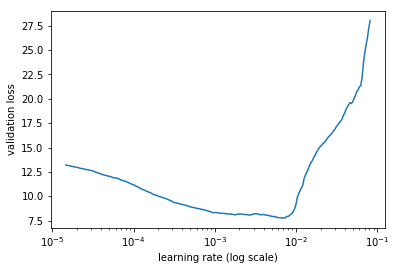

In [265]:
learn.lr_find()
learn.sched.plot()

In [266]:
lr=3e-3

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      5.329972   5.333483  
    1      4.327437   4.38393                               
    2      3.923274   4.008184                              
    3      3.730714   3.858946                              
    4      3.643796   3.780701                              
    5      3.305944   3.679653                              
    6      3.060649   3.560284                              
    7      3.153685   3.56651                               
    8      3.025824   3.481106                              
    9      2.8496     3.451676                              
    10     2.820063   3.504175                              
Validation:  77%|███████▋  | 20/26 [00:02<00:00,  8.80it/s] 

In [ ]:
learn.save('initial')

In [ ]:
learn.load('initial')

### Test

In [270]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what aspects of of and and and and how how be be be be ? ? _eos_

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
when minister the minister minister minister minister minister to health health and and and mental mental and ? ? ? _eos_ _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growing form

## Bidir

In [289]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

Seq2SeqRNN_Bidir.forward >>>>>>

In [290]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
to_gpu(rnn)
self = rnn

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [291]:
it = iter(trn_dl)
x, y = next(it)
inp = V(x)

In [292]:
#     def forward(self, inp):
#         sl,bs = inp.size()
#         h = self.initHidden(bs)
#         emb = self.emb_enc_drop(self.emb_enc(inp))
#         enc_out, h = self.gru_enc(emb, h)
#         h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
#         h = self.out_enc(self.drop_enc(h))


In [293]:
sl,bs = inp.size()
sl, bs

(33, 125)

In [294]:
h = self.initHidden(bs)
h.size()

torch.Size([4, 125, 256])

In [295]:
emb = self.emb_enc_drop(self.emb_enc(inp))
emb.shape

torch.Size([33, 125, 300])

In [284]:
enc_out, h = self.gru_enc(emb, h)
enc_out.shape, h.shape

(torch.Size([33, 125, 512]), torch.Size([4, 125, 256]))

In [296]:
h.view(2,2,bs,-1).shape

torch.Size([2, 2, 125, 256])

In [297]:
h.view(2,2,bs,-1).permute(0,2,1,3).shape

torch.Size([2, 125, 2, 256])

In [298]:
h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().shape

torch.Size([2, 125, 2, 256])

In [299]:
h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
h.shape

torch.Size([2, 125, 512])

In [304]:
h = self.out_enc(h)
h.shape

torch.Size([2, 125, 300])

In [300]:
#         dec_inp = V(torch.zeros(bs).long())
#         res = []
#         for i in range(self.out_sl):
#             emb = self.emb_dec(dec_inp).unsqueeze(0)
#             outp, h = self.gru_dec(emb, h)
#             outp = self.out(self.out_drop(outp[0]))
#             res.append(outp)
#             dec_inp = V(outp.data.max(1)[1])
#             if (dec_inp==1).all(): break
#         return torch.stack(res)


In [305]:
dec_inp = V(torch.zeros(bs).long())
res = []
dec_inp.shape

torch.Size([125])

In [306]:
#         for i in range(self.out_sl):
i = 0 
emb = self.emb_dec(dec_inp).unsqueeze(0)
self.emb_dec(dec_inp).shape, emb.shape

(torch.Size([125, 300]), torch.Size([1, 125, 300]))

In [307]:
outp, h = self.gru_dec(emb, h)
outp.shape, h.shape

(torch.Size([1, 125, 300]), torch.Size([2, 125, 300]))

In [308]:
outp[0].shape, self.out_drop(outp[0]).shape

(torch.Size([125, 300]), torch.Size([125, 300]))

In [309]:
outp = self.out(self.out_drop(outp[0]))
outp.shape

torch.Size([125, 17573])

In [310]:
res.append(outp)

In [313]:
dec_inp = V(outp.data.max(1)[1])
dec_inp.shape

torch.Size([125])

In [315]:
dec_inp = V(torch.zeros(bs).long())
res = []
for i in range(self.out_sl):
    emb = self.emb_dec(dec_inp).unsqueeze(0)
    outp, h = self.gru_dec(emb, h)
    outp = self.out(self.out_drop(outp[0]))
    res.append(outp)
    dec_inp = V(outp.data.max(1)[1])
    if (dec_inp==1).all(): break
returned_value = torch.stack(res)

In [316]:
return_value.shape, len(res), [o.shape for o in res]

(torch.Size([29, 125, 17573]),
 29,
 [torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573]),
  torch.Size([125, 17573])])

<<<<<<<

In [317]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

In [ ]:
learn.save('bidir')

## Teacher forcing

In [323]:
??Stepper

In [320]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [321]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [322]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      4.460622   12.661013 
    1      3.468132   7.138729                              
    2      3.235244   6.202878                              
    3      3.101616   5.454283                              
    4      3.135989   4.823736                              
    5      2.980696   4.933402                              
    6      2.91562    4.287475                              
    7      3.032661   3.975346                              
    8      3.103834   3.790773                              
    9      3.121457   3.578682                              
    10     2.917534   3.532427                              
    11     3.326946   3.490643                              



[3.490643]

In [ ]:
learn.save('forcing')

## Attentional model

In [324]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [325]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [326]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


Seq2SeqAttnRNN >>>>>>

In [ ]:
# class Seq2SeqAttnRNN(nn.Module):
#     def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
#         super().__init__()
#         self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
#         self.nl,self.nh,self.out_sl = nl,nh,out_sl
#         self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
#         self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
#         self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
#         self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
#         self.emb_enc_drop = nn.Dropout(0.15)
#         self.out_drop = nn.Dropout(0.35)
#         self.out = nn.Linear(em_sz_dec, len(itos_dec))
#         self.out.weight.data = self.emb_dec.weight.data

#         self.W1 = rand_p(nh, em_sz_dec)
#         self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
#         self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
#         self.V = rand_p(em_sz_dec)


In [328]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
self = rnn

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [329]:
self.emb_enc

Embedding(24804, 300, padding_idx=1)

In [331]:
self.nl,self.nh,self.out_sl

(2, 256, 29)

In [332]:
self.gru_enc

GRU(300, 256, num_layers=2, dropout=0.25)

In [333]:
self.out_enc

Linear(in_features=256, out_features=300, bias=False)

In [335]:
self.out, self.emb_dec

(Linear(in_features=300, out_features=17573, bias=True),
 Embedding(17573, 300, padding_idx=1))

In [337]:
(self.out.weight.data == self.emb_dec.weight.data).all()

True

In [338]:
self.W1 = rand_p(nh, em_sz_dec)
self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
self.V = rand_p(em_sz_dec)

In [342]:
# def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
sz = nh, em_sz_dec
sz, torch.randn(sz).shape, math.sqrt(sz[0])

((256, 300), torch.Size([256, 300]), 16.0)

In [348]:
self.W1.shape, self.l2, self.l3, self.V.shape

(torch.Size([256, 300]),
 Linear(in_features=300, out_features=300, bias=True),
 Linear(in_features=556, out_features=300, bias=True),
 torch.Size([300]))

<<<<<<<

`Seq2SeqAttnRNN.forward` >>>>>>

In [350]:
#     def forward(self, inp, y=None, ret_attn=False):
#         sl,bs = inp.size()
#         h = self.initHidden(bs)
#         emb = self.emb_enc_drop(self.emb_enc(inp))
#         enc_out, h = self.gru_enc(emb, h)
#         h = self.out_enc(h)

# ...

#     def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [400]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
to_gpu(rnn)
self = rnn

3109 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [401]:
it = iter(trn_dl)
x, y = next(it)
inp = V(x)

sl,bs = inp.size()
sl,bs

(33, 125)

In [402]:
h = self.initHidden(bs)
h.shape

torch.Size([2, 125, 256])

In [403]:
emb = self.emb_enc_drop(self.emb_enc(inp))
emb.shape

torch.Size([33, 125, 300])

In [404]:
enc_out, h = self.gru_enc(emb, h)
enc_out.shape, h.shape

(torch.Size([33, 125, 256]), torch.Size([2, 125, 256]))

In [405]:
h = self.out_enc(h)
h.shape

torch.Size([2, 125, 300])

In [406]:
#         dec_inp = V(torch.zeros(bs).long())
#         res,attns = [],[]
#         w1e = enc_out @ self.W1

In [407]:
dec_inp = V(torch.zeros(bs).long())
dec_inp.shape

torch.Size([125])

In [408]:
res,attns = [],[]

Here we make use of `enc_out` - the output of encoder that has all tokens in the input sentence (`sl=33` tokens).

`W1` transform `enc_out` from hidden dimension `nh=256` to decoder embedding dimension `em_sz_dec=300`, making `w1e`.

In [409]:
w1e = enc_out @ self.W1

In [410]:
enc_out.shape, self.W1.shape, w1e.shape

(torch.Size([33, 125, 256]),
 torch.Size([256, 300]),
 torch.Size([33, 125, 300]))

In [411]:
#         for i in range(self.out_sl):
#             w2h = self.l2(h[-1])
#             u = F.tanh(w1e + w2h)
#             a = F.softmax(u @ self.V, 0)
#             attns.append(a)
#             Xa = (a.unsqueeze(2) * enc_out).sum(0)
#             emb = self.emb_dec(dec_inp)
#             wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
#             outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
#             outp = self.out(self.out_drop(outp[0]))
#             res.append(outp)
#             dec_inp = V(outp.data.max(1)[1])
#             if (dec_inp==1).all(): break
#             if (y is not None) and (random.random()<self.pr_force):
#                 if i>=len(y): break
#                 dec_inp = y[i]

#         res = torch.stack(res)
#         if ret_attn: res = res,torch.stack(attns)
#         return res

In [412]:
self.out_sl

29

In [413]:
#         for i in range(self.out_sl):
i = 0
w2h = self.l2(h[-1])
h.shape, h[-1].shape

(torch.Size([2, 125, 300]), torch.Size([125, 300]))

`l2` transform `h` from hidden dim to embedding dim, making  `w2h`.

In [414]:
self.l2, w2h.shape

(Linear(in_features=300, out_features=300, bias=True), torch.Size([125, 300]))

`w1e + w2h` combines information from `enc_out` and `h` and stays the same dim as `w1e` (by broadcast), which has both location-in-sentence info (`sl=33`) and embedding dimension (`em_sz_dec=300`). This combining makes `u`.

In [415]:
u = F.tanh(w1e + w2h)
w1e.shape, w2h.shape, u.shape

(torch.Size([33, 125, 300]),
 torch.Size([125, 300]),
 torch.Size([33, 125, 300]))

`u @ self.V` transforms u into sentence dimension (`sl=33`), removing embedding dimension. After a softmax this becomes `a`, attention.

In [416]:
u.shape, self.V.shape, (u @ self.V).shape

(torch.Size([33, 125, 300]), torch.Size([300]), torch.Size([33, 125]))

In [417]:
F.softmax(u @ self.V).shape

torch.Size([33, 125])

`a` is attention, each of `sl=33` locations in sentence has an element in `a`.

In [418]:
a = F.softmax(u @ self.V, 0)
a.shape

torch.Size([33, 125])

records attention for each recurrent loop, i.e., each output location 

In [419]:
attns.append(a)

In [420]:
a.shape, a.unsqueeze(2).shape, enc_out.shape

(torch.Size([33, 125]), torch.Size([33, 125, 1]), torch.Size([33, 125, 256]))

This is an elementwise multiplication, not matrix multiplication. This applies attention `a` to `enc_out`. This tells us what locations of `enc_out` are important.

In [422]:
(a.unsqueeze(2) * enc_out).shape

torch.Size([33, 125, 256])

This `sum(0)` removes location-in-sentence dimension, making `Xa`, which is in the hidden dim.

In [423]:
Xa = (a.unsqueeze(2) * enc_out).sum(0)
Xa.shape

torch.Size([125, 256])

This is just the old decoder embedding from vocab to embedding dim.

In [386]:
dec_inp.shape, self.emb_dec

(torch.Size([125]), Embedding(17573, 300, padding_idx=1))

In [387]:
emb = self.emb_dec(dec_inp)
emb.shape

torch.Size([125, 300])

Here `emb` and `Xa` are concatenated emb dim 300 + hidden dim 256, into 556.

In [388]:
emb.shape, Xa.shape, torch.cat([emb, Xa], 1).shape

(torch.Size([125, 300]), torch.Size([125, 256]), torch.Size([125, 556]))

`l3` tranform this 556 dim into embdding dim 300, making `wgt_enc`. 

In [389]:
self.l3

Linear(in_features=556, out_features=300, bias=True)

In [390]:
wgt_enc = self.l3(torch.cat([emb, Xa], 1))
wgt_enc.shape

torch.Size([125, 300])

In [393]:
wgt_enc.shape, wgt_enc.unsqueeze(0).shape, h.shape

(torch.Size([125, 300]), torch.Size([1, 125, 300]), torch.Size([2, 125, 300]))

In [392]:
self.gru_dec

GRU(300, 300, num_layers=2, dropout=0.1)

compare to `Seq2SeqRNN`: 
```
emb = self.emb_dec(dec_inp).unsqueeze(0)
outp, h = self.gru_dec(emb, h)
```

`wgt_enc` replaces `emb` in the ordinary non-attention model.

In [397]:
outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
outp.shape, h.shape

(torch.Size([1, 125, 300]), torch.Size([2, 125, 300]))

In [395]:
outp[0].shape, self.out

(torch.Size([125, 300]),
 Linear(in_features=300, out_features=17573, bias=True))

In [396]:
outp = self.out(self.out_drop(outp[0]))
outp.shape

torch.Size([125, 17573])

<<<<<<<

In [424]:
lr=2e-3

In [425]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

epoch      trn_loss   val_loss                              
    0      3.852992   9.844728  
    1      3.197897   6.722522                              
    2      3.114484   5.216027                              
    3      3.125994   4.564064                              
    4      2.843633   3.885162                              
    5      2.750565   3.969477                              
    6      2.688122   3.910155                              
    7      2.922969   3.570431                              
    8      2.899515   3.473084                              
    9      2.82711    3.367644                              
    10     2.791721   3.352926                              
    11     2.884954   3.284298                              
    12     2.585333   3.250779                              
    13     2.589916   3.258076                              
    14     2.544507   3.256427                              


[array([3.25643])]

In [426]:
learn.save('attn')

In [427]:
learn.load('attn')

### Test

In [433]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [434]:
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what components components components be be performance be be relevant be and and ? ? ? _eos_

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what is the minister minister minister minister minister health health health , mental health mental health ? ? ? _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the i

In [435]:
attn = to_np(attns[...,180])

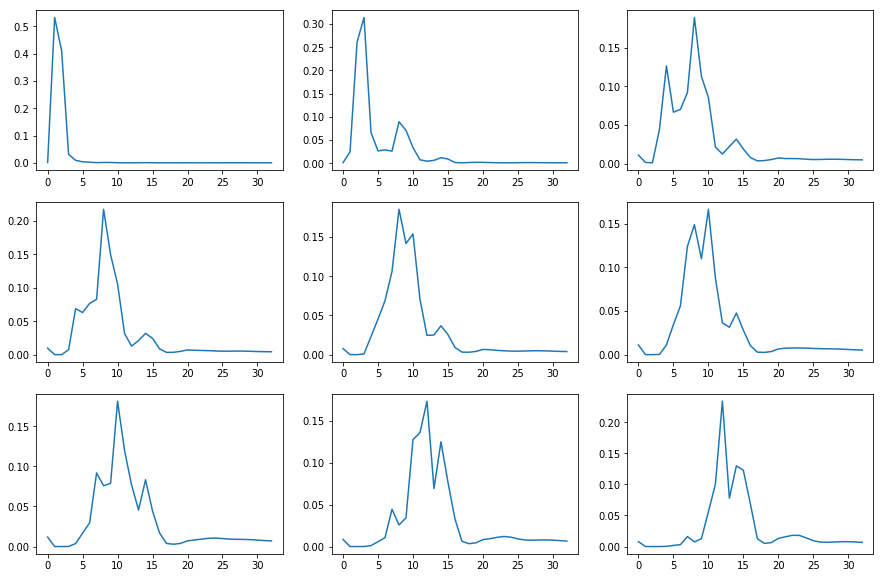

In [436]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

look at attentions >>>>>>>

In [437]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [441]:
x.shape, y.shape

(torch.Size([33, 200]), torch.Size([29, 200]))

In [444]:
probs.shape, attns.shape, val_dl.batch_size

(torch.Size([29, 200, 17573]), torch.Size([29, 33, 200]), 200)

In [448]:
(attns[...,180]==attns[:,:,180]).all()

True

In [449]:
attns[...,180].shape

torch.Size([29, 33])

In [450]:
attn = to_np(attns[...,180])

In [451]:
attn.shape

(29, 33)

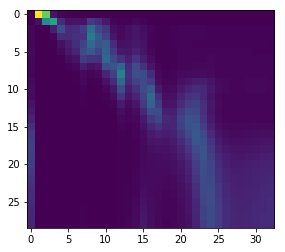

In [454]:
plt.imshow(attn);

<<<<<<<<

## All

In [ ]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

compare >>>>>>>

flip compare the 2 below for `Seq2SeqRNN_All` v.s. `Seq2SeqAttnRNN`

<<<<<<<

In [ ]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      3.817306   7.527982  
    1      3.239813   5.82099                               
    2      3.06717    5.437195                              
    3      3.077923   4.718295                              
    4      2.952973   4.337892                              
    5      3.018182   3.994012                              
    6      2.761607   3.777056                              
    7      2.913683   3.595531                              
    8      2.91521    3.46984                               
    9      2.921533   3.370839                              
    10     2.913826   3.336167                              
    11     2.746896   3.37274                               
    12     2.695839   3.332427                              
    13     2.531583   3.341861                              
    14     2.524642   3.324184                              



[3.3241842]

### Test

In [ ]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quels facteurs pourraient influer sur le choix de leur emplacement ? _eos_
what factors influencetheir location ? _eos_
what factors might affect the choice of their ? ? _eos_

qu’ est -ce qui ne peut pas changer ? _eos_
what can not change ? _eos_
what can not change change _eos_

que faites - vous ? _eos_
what do you do ? _eos_
what do you do ? _eos_

qui réglemente les pylônes d' antennes ? _eos_
who regulates antenna towers ? _eos_
who regulates the antenna ? ? _eos_

où sont - ils situés ? _eos_
where are they located ? _eos_
where are they located ? _eos_

quelles sont leurs compétences ? _eos_
what are their qualifications ? _eos_
what are their skills ? _eos_

qui est victime de harcèlement sexuel ? _eos_
who experiences sexual harassment ? _eos_
who is victim harassment harassment ? _eos_

quelles sont les personnes qui visitent les communautés autochtones ? _eos_
who visits indigenous communities ? _eos_
who are the people people ? ?

pourquoi ces trois points en particulier 